In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from datetime import datetime

In [2]:
%matplotlib inline
import matplotlib.pylab

In [3]:
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv("NSE_2000_2018.csv")

In [61]:
data.head()

Unnamed: 0         Date     Open     High      Low   Close  Shares Traded  \
0           0  03-Jan-2000  1482.15  1592.90  1482.15  1592.2       25358322   
1           1  04-Jan-2000  1594.40  1641.95  1594.40  1638.7       38787872   
2           2  05-Jan-2000  1634.55  1635.50  1555.05  1595.8       62153431   
3           3  06-Jan-2000  1595.80  1639.00  1595.80  1617.6       51272875   
4           4  07-Jan-2000  1616.60  1628.25  1597.20  1613.3       54315945   

   Turnover (Rs. Cr)  
0             884.15  
1            1973.69  
2            3084.79  
3            2531.18  
4            1914.63

In [62]:
data.shape

(4526, 8)

In [9]:
# Getting Stock Prices

In [63]:
stock_price = data[['Date','Open']]

In [64]:
stock_price.head()

Date     Open
0  03-Jan-2000  1482.15
1  04-Jan-2000  1594.40
2  05-Jan-2000  1634.55
3  06-Jan-2000  1595.80
4  07-Jan-2000  1616.60

In [12]:
stock_price.shape

(4526, 2)

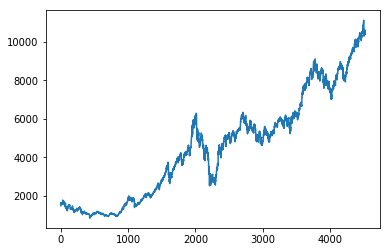

In [65]:
plt.plot(stock_price['Open'])

# Model - Convolution1D with Max Pooling Layer

In [14]:
def make_timeseries_instances(timeseries, window_size=10):
    """Make input features and prediction targets from a `timeseries` for use in machine learning.
    :return: A tuple of `(X, y, q)`.  `X` are the inputs to a predictor, a 3D ndarray with shape
      ``(timeseries.shape[0] - window_size, window_size, timeseries.shape[1] or 1)``.  For each row of `X`, the
      corresponding row of `y` is the next value in the timeseries.  The `q` or query is the last instance, what you would use
      to predict a hypothetical next (unprovided) value in the `timeseries`.
    :param ndarray timeseries: Either a simple vector, or a matrix of shape ``(timestep, series_num)``, i.e., time is axis 0 (the
      row) and the series is axis 1 (the column).
    :param int window_size: The number of samples to use as input prediction features (also called the lag or lookback).
    """
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q

In [15]:
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten
from keras.models import Sequential

Using TensorFlow backend.


In [16]:
def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

In [22]:
def evaluate_timeseries(timeseries, window_size=30,test_ratio=0.30):
    """Create a 1D CNN regressor to predict the next value in a `timeseries` using the preceding `window_size` elements
    as input features and evaluate its performance.
    :param ndarray timeseries: Timeseries data with time increasing down the rows (the leading dimension/axis).
    :param int window_size: The number of previous timeseries values to use to predict the next.
    """
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # Convert 1D vectors to 2D column vectors

    nb_samples, nb_series = timeseries.shape
    print '\n\nTimeseries ({} samples by {} series):\n'.format(nb_samples, nb_series), timeseries
    model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    print'\n\nModel with input size {}, output size {}, {} conv filters of length {}'.format(model.input_shape, model.output_shape, nb_filter, filter_length)
    model.summary()

    X, y, q = make_timeseries_instances(timeseries, window_size)
    print'\n\nInput features:', X, '\n\nOutput labels:', y, '\n\nQuery vector:', q
    test_size = int(test_ratio * nb_samples)           # In real life you'd want to use 0.2 - 0.5
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=30, batch_size=2, validation_data=(X_test, y_test))

    pred = model.predict(X_test)
    print '\n\nactual', 'predicted'
    for actual, predicted in zip(y_test, pred.squeeze()):
        print actual.squeeze(), predicted
    print 'next', model.predict(q).squeeze()
    return y_test.flatten(),pred.flatten()

In [24]:
actual,predicted = evaluate_timeseries(stock_price['Open'],window_size=20)



Timeseries (4526 samples by 1 series):
[[  1482.15]
 [  1594.4 ]
 [  1634.55]
 ..., 
 [ 10488.95]
 [ 10479.95]
 [ 10428.3 ]]


Model with input size (None, 20, 1), output size (None, 1), 4 conv filters of length 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8)                 0         
__________________________________________________________

/Users/apple/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(20, 1), filters=4, kernel_size=5)`
/Users/apple/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", kernel_size=5, filters=4)`



Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


Input features: [[[  1482.15]
  [  1594.4 ]
  [  1634.55]
  ..., 
  [  1600.5 ]
  [  1603.65]
  [  1598.35]]

 [[  1594.4 ]
  [  1634.55]
  [  1595.8 ]
  ..., 
  [  1603.65]
  [  1598.35]
  [  1546.2 ]]

 [[  1634.55]
  [  1595.8 ]
  [  1616.6 ]
  ..., 
  [  1598.35]
  [  1546.2 ]
  [  1554.2 ]]

 ..., 
 [[ 11120.85]
  [ 11018.8 ]
  [ 11044.55]
  ..., 
  [ 10408.1 ]
  [ 10526.55]
  [ 10615.2 ]]

 [[ 11018.8 ]
  [ 11044.55]
  [ 10938.2 ]
  ..., 
  [ 10526.55]
  [ 10615.2 ]
  [ 10488.95]]

 [[ 11044.55]
  [ 10938.2 ]
  [ 10604.3 ]
  ..., 
  [ 10615.2 ]
  [ 10488.95]
  [ 10479.95]]] 

Output labels: [[  1546.2 ]
 [  1554.2 ]
 [  1591.25]
 ..., 
 [ 10488.95]
 [ 10479.95]
 [ 10428.3 ]] 

Query vector: [[[ 10938.2 ]
  [ 10604.3 ]
  [ 10295.15]
  [ 10607.2 ]
  [ 10518.5 ]
  [ 10416.5 ]
  [ 10518.2 ]
  [ 10585.75]
  [ 10537.9 ]
  [ 10596.2 ]
  [ 10488.9 ]
  [ 103

6120.45 6125.32
6072.15 6092.0
6098.7 6122.86
5997.35 6160.15
5941.1 6152.84
5908.3 6098.4
5895.0 6064.77
5900.05 5996.61
5907.9 5976.47
5848.75 5960.29
5771.75 5941.33
5709.35 5954.7
5748.95 5905.12
5820.4 5847.16
5841.9 5835.6
5805.75 5769.14
5754.15 5817.42
5639.9 5895.81
5638.05 5876.05
5606.95 5767.89
5627.95 5722.79
5647.95 5724.22
5749.5 5681.37
5834.1 5698.63
5885.5 5704.29
5811.95 5807.95
5794.75 5901.54
5889.95 5919.77
5833.15 5912.73
5834.6 5932.65
5869.9 5933.86
5894.5 5933.04
6000.5 5935.57
5991.2 5946.83
5930.8 5951.17
5972.25 6029.24
5984.7 6028.25
6057.2 5999.15
6009.75 6069.26
6064.3 6055.12
6032.2 6125.66
5970.4 6109.05
5937.95 6060.97
5869.95 6063.09
5836.05 5982.18
5738.35 5929.41
5776.9 5931.68
5750.05 5858.61
5682.4 5856.05
5664.9 5816.81
5549.3 5802.24
5510.05 5773.79
5606.7 5682.61
5600.25 5689.44
5715.4 5602.76
5705.45 5621.67
5497.55 5641.63
5353.45 5766.55
5494.45 5745.9
5282.8 5524.59
5428.75 5502.74
5499.4 5498.62
5426.5 5446.7
5233.45 5528.29
5316.5 5558.8

8175.45 8369.94
8123.55 8309.38
8054.55 8221.68
8086.35 8214.45
8104.9 8152.43
8030.35 8152.53
7956.55 8135.16
7788.25 8120.84
7877.6 8120.86
7838.8 7978.05
7762.45 7987.86
7732.95 7919.87
7848.75 7912.83
7823.15 7875.19
7788.5 7888.37
7841.9 7878.52
7869.5 7874.09
7837.0 7895.25
7837.15 7898.79
7910.6 7935.98
7936.25 7933.12
7958.15 7980.51
7976.7 7969.91
7902.3 8005.82
7817.6 8035.05
7816.55 7989.66
7738.5 7933.83
7695.5 7867.31
7643.3 7821.6
7699.6 7815.77
7558.2 7778.61
7659.15 7783.03
7725.25 7725.36
7783.05 7721.13
7828.9 7724.44
7745.65 7728.29
7829.4 7879.95
7830.45 7919.87
7888.75 7920.73
7863.2 7972.14
7929.2 7964.36
7938.6 8012.15
7897.8 7979.07
7938.45 7952.76
7924.55 7985.42
7828.4 7957.41
7788.05 7945.5
7673.35 7947.81
7611.65 7871.54
7527.45 7765.88
7587.2 7745.24
7557.9 7690.53
7467.4 7681.33
7561.65 7625.46
7420.35 7599.02
7381.8 7585.83
7357.0 7594.74
7376.65 7550.54
7355.7 7516.15
7468.75 7504.84
7469.6 7420.08
7426.5 7426.06
7413.35 7526.43
7589.5 7533.5
7566.65 756

#   Accuracy and Error Analysis 

# MAE 

In [25]:
mae = np.sum(np.absolute(actual -predicted))/len(actual)

In [26]:
mae

96.237562105632804

In [27]:
avg_value = np.mean(actual)

In [28]:
avg_value

7819.9956890198955

In [29]:
(mae/avg_value) * 100

1.2306600403982393

In [40]:
mae_average = (np.absolute(actual -predicted)/actual)*100

In [41]:
len(mae_average)

1357

In [44]:
pd.Series(mae_average).describe()

count    1357.000000
mean        1.266228
std         1.079347
min         0.000037
25%         0.439181
50%         1.009384
75%         1.806104
max         7.716579
dtype: float64

In [46]:
len(mae_average[mae_average >2.0])

275

In [60]:
len(mae_average[mae_average >2.0])/float(len(mae_average))

0.20265291083271925

In [48]:
len(mae_average[mae_average < 0.5])

386

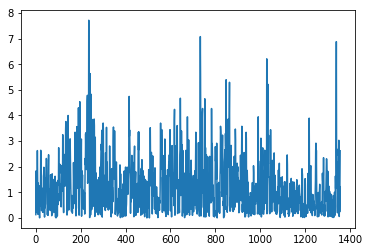

In [45]:
plt.plot(pd.Series(mae_average))

# Plotting

In [50]:
len(actual)

1357

In [51]:
df = pd.DataFrame({'Date':list(stock_price.iloc[-1357:]['Date']), 'acutal':list(actual.flatten()),'predicted':list(predicted.flatten())})

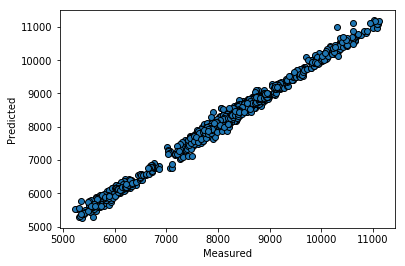

In [52]:
fig, ax = plt.subplots()
ax.scatter(actual.flatten(), predicted.flatten(), edgecolors=(0, 0, 0))
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [53]:
df.head()

Date   acutal    predicted
0  07-Sep-2012  5309.45  5302.608398
1  08-Sep-2012  5343.65  5311.658691
2  10-Sep-2012  5361.90  5263.237305
3  11-Sep-2012  5336.10  5323.814453
4  12-Sep-2012  5404.45  5381.885254

In [54]:
df.columns

Index([u'Date', u'acutal', u'predicted'], dtype='object')

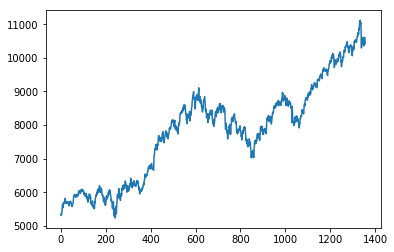

In [56]:
plt.plot(pd.Series(actual))

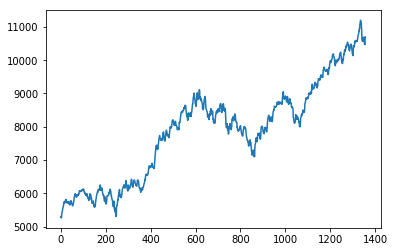

In [57]:
plt.plot(pd.Series(predicted))

# Plotting Actual and Predicted in Same Graph

In [34]:
from matplotlib import pyplot

In [35]:
values = df.values

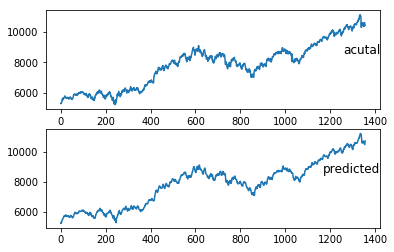

In [37]:
groups = [1,2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()